# A Neural Algorithm of Artistic Style

Would like to thank this repo for the image: https://www.kaggle.com/code/soumya044/artistic-neural-style-transfer-using-pytorch/data?select=starrynight.jpg

In [1]:
!pip install -q wandb watermark
# !pip install wandb --upgrade

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision import models

device = torch.device('cuda' if torch.has_cuda else 'cpu')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import wandb
from tqdm import tqdm

import warnings
warnings.simplefilter('ignore')

%load_ext watermark
%watermark -a "Aneesh Aparajit G" -p torch,torchvision,wandb,numpy,matplotlib

print(f'Device: {device}')

Author: Aneesh Aparajit G

torch      : 1.11.0
torchvision: 0.12.0
wandb      : 0.12.21
numpy      : 1.21.6
matplotlib : 3.5.3

Device: cuda


Shape: (965, 1716, 3)


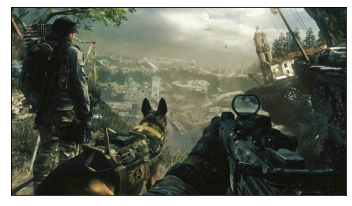

In [3]:
img = np.array(Image.open('../input/nst-images/call-of-duty-ghosts.jpeg'))

print(f'Shape: {img.shape}')

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

Shape: (630, 1200, 3)


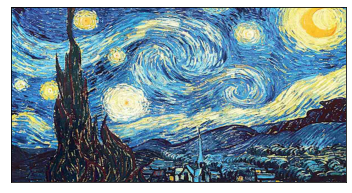

In [4]:
img = np.array(Image.open('../input/nst-images/starrynight.jpeg'))

print(f'Shape: {img.shape}')

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
def load_image(file_path: str, img_shape=(356, 356)) -> torch.Tensor:
    img = Image.open(file_path).convert("RGB")
    transform = T.Compose([
        T.Resize(img_shape),
        T.ToTensor(),
    ])
    
    img = transform(img).unsqueeze(0)
#     img = img / 255.0
    
    print(f'''File Path: {file_path}
    * Shape: {img.shape}
    * Max  : {img.min()}
    * Min  : {img.max()}
''')
    
    plt.imshow(img[0].permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'File Path: {file_path}')
    plt.show()
    return img.to(device)

File Path: ../input/nst-images/starrynight.jpeg
    * Shape: torch.Size([1, 3, 356, 356])
    * Max  : 0.0
    * Min  : 1.0



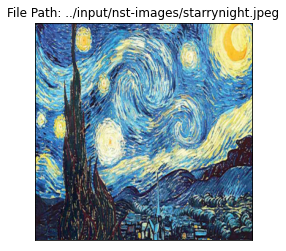

In [6]:
style_img = load_image(file_path='../input/nst-images/starrynight.jpeg')

File Path: ../input/nst-images/call-of-duty-ghosts.jpeg
    * Shape: torch.Size([1, 3, 356, 356])
    * Max  : 0.027450980618596077
    * Min  : 0.9843137264251709



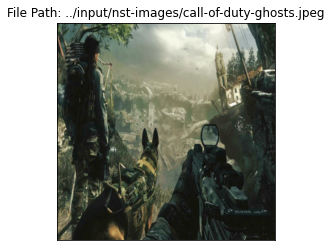

In [7]:
content_img = load_image(file_path='../input/nst-images/call-of-duty-ghosts.jpeg')

# Loss Functions

$$\mathcal{L}_{total} = \alpha \mathcal{L}_{\text{content}} + \beta \mathcal{L}_{\text{style}}$$

## Content Loss

The content loss is a function that represents a weighted version of the content distance for an individual layer. The function takes the feature maps $F_{XL}$ of the the __layer $L$__ in a network processing input $X$ and returns the weighted content distance $w_{CL}D_C^L(X, C)$ between the input image $X$ and the content image $C$. The feature maps of the content image ($F_{CL}$) as an input. The distance $\|F_{XL}-F_{CL}\|_2$ is the MSE.

In [8]:
class ContentLoss(nn.Module):
    def __init__(self, content_img: torch.Tensor) -> None:
        super(ContentLoss, self).__init__()
        self.content_img = content_img
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.mse_loss(input=x, target=self.content_img, reduce='mean')

## Style Loss

The style loss module is implemented in a very similar way to that of the content loss module. It will act as a transparent layer in the network that computes the style loss of that layer. In order to calculate the style loss, we need to compute the gram matrix $G_{XL}$.

### [Gram Matrix](https://en.wikipedia.org/wiki/Gram_matrix)
$$G(X) = \langle X, X\rangle = X^TX$$

- When we look at the Gram matrix, it would seem similar to a correlation matrix. 
- A correlation essentially tells us how one vector varies based on an other vector.
- This precisely the Gramian matrix does. It essentially would tell us how pixel is driven by the other pixels.
- As a result, it would give us information about important information like the texture which needs to replicated by the target image.


After finding the Gram matrix for the feature map then find the MSE loss with the Gramian matrix of the style image itself at each of the different levels of the encoder.

It would make more sense in the implementatons.

In [9]:
def gram_matrix(x: torch.Tensor) -> torch.Tensor:
    '''Calculates Gram Matrix.
    
    Args:
    -----
        - x.shape = [b, c, h, w]
            - b: batch size
            - c: # of color channels
            - h: height of the image
            - w: width of the image
    
    Returns:
    --------
        - Gram matrix
    '''
    b, c, h, w = x.shape
    x = x.view(c, h * w)
    return torch.mm(x, x.t())

In [10]:
class StyleLoss(nn.Module):
    def __init__(self, style_img: torch.Tensor) -> None:
        super(StyleLoss, self).__init__()
        self.style_img = style_img
        self.style_mat = gram_matrix(style_img)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = gram_matrix(x)
        return F.mse_loss(input=x, target=self.style_mat, reduce='mean')

# Putting it all together

## VGG19

In [11]:
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)
    
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

We will use the convolutions just after a "MaxPooling" layer.

In [12]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super(Encoder, self).__init__()
        self.selected_features = ['0', '5', '10', '19', '28']
        self.model = models.vgg19(pretrained=True).features

        # freeze all VGG parameters since we're only optimizing the target image
        for param in self.model.parameters():
            param.requires_grad_(False)
    
    def forward(self, x: torch.Tensor) -> tuple:
        '''Returns the features and the final X value.'''
        features = []
        for ix, layer in enumerate(self.model):
            x = layer(x)
            if str(ix) in self.selected_features:
                features.append(torch.clone(x))
        return features, x

In [13]:
wandb.login()

False

In [14]:
N_EPOCHS      = 6000
LEARNING_RATE = 0.003
CONTENT_ALPHA = 1
STYLE_BETA    = 0.05

config = dict(
    epochs=N_EPOCHS, 
    learning_rate=LEARNING_RATE,
    architecture="Neural Style Transfer",
    content_alpha=CONTENT_ALPHA,
    style_beta=STYLE_BETA
)

In [15]:
def model_pipeline(config):
    with wandb.init(project='neural-style-transfer', config=config):
        config = wandb.config
        
        # make the model
        model, target, content_criterion, style_criterion, optimizer = make(content_img=content_img, 
                                                                            style_img=style_img, 
                                                                            config=config)
        # train the model
        train(model, target, content_criterion, style_criterion, optimizer, config)
        
    return target

In [16]:
def make(content_img: torch.Tensor, style_img: torch.Tensor, config: dict):
    model = Encoder().to(device)
    target = torch.clone(content_img).requires_grad_(True).to(device)
    
    features, x = model.forward(content_img)
    content_criterion = nn.Sequential(
        ContentLoss(content_img=x)
    )
    
    features, x = model.forward(style_img)
    style_criterion = nn.Sequential()
        
    for ix, feature in enumerate(features):
        style_criterion.add_module(f'conv_{ix}_1', StyleLoss(style_img=feature))
    
    optimizer = optim.Adam([target], lr=config.learning_rate)
    return model, target, content_criterion, style_criterion, optimizer

In [17]:
def train(model: nn.Module, target: torch.Tensor, 
          content_criterion: nn.Module, style_criterion: nn.Module, 
          optimizer: optim, config: dict):
    
    wandb.watch(model, criterion=[content_criterion, style_criterion], log='all', log_freq=10)
    
    wandb.log({
        "epoch": 0,
        "target": [wandb.Image(target)],
        "content": [wandb.Image(content_img)],
        "style": [wandb.Image(style_img)]
    }, step=0)

    for epoch in tqdm(range(config.epochs)):
        
        loss = train_step(target, model, content_criterion, style_criterion, optimizer, config)
        
        if (epoch+1)%500 == 0:
            print(f'Loss: {float(loss):.3f}')
            wandb.log({
                "epoch": epoch+1,
                "target": [wandb.Image(target)],
                "loss": float(loss)
            }, step=epoch+1)

style_weights = [1, 0.75, 0.2, 0.2, 0.2]
            
def train_step(target: torch.Tensor, model: nn.Module, content_criterion: nn.Sequential, 
               style_criterion: nn.Sequential, optimizer: optim, config: dict):
    content_loss = 0.0
    style_loss = 0.0
    
    features, x = model.forward(torch.clone(target))
    
    for layer in content_criterion:
        content_loss += layer(x)
    
    for ix, layer in enumerate(style_criterion):
        style_loss += layer(features[ix]) * style_weights[ix]
    
    total_loss = config.content_alpha * content_loss + config.style_beta * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    return total_loss

In [18]:
config

{'epochs': 6000,
 'learning_rate': 0.003,
 'architecture': 'Neural Style Transfer',
 'content_alpha': 1,
 'style_beta': 0.05}

In [19]:
target = model_pipeline(config=config)

  8%|▊         | 509/6000 [00:13<02:24, 37.92it/s]

Loss: 774602.812


 17%|█▋        | 1009/6000 [00:26<02:10, 38.29it/s]

Loss: 114605.742


 25%|██▌       | 1503/6000 [00:39<02:56, 25.46it/s]

Loss: 47611.398


 33%|███▎      | 2009/6000 [00:52<01:43, 38.69it/s]

Loss: 29091.605


 42%|████▏     | 2509/6000 [01:05<01:30, 38.63it/s]

Loss: 20034.312


 50%|█████     | 3009/6000 [01:18<01:17, 38.61it/s]

Loss: 14930.259


 58%|█████▊    | 3509/6000 [01:31<01:04, 38.63it/s]

Loss: 11453.086


 67%|██████▋   | 4009/6000 [01:44<00:52, 38.11it/s]

Loss: 8907.814


 75%|███████▌  | 4509/6000 [01:57<00:38, 38.27it/s]

Loss: 7080.995


 83%|████████▎ | 5009/6000 [02:10<00:26, 38.04it/s]

Loss: 5960.744


 92%|█████████▏| 5509/6000 [02:23<00:12, 38.60it/s]

Loss: 4944.524


100%|██████████| 6000/6000 [02:35<00:00, 38.46it/s]

Loss: 4519.887


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁
epoch,6000
loss,4519.88721


# Results

The results, can be viewed in [Weights and Biases](https://wandb.ai/aaparajit02/neural-style-transfer).

## Experiments

I conducted two experiments.
1. Starting from random noise
2. Starting from the content imahe itself.

The results after 6000 epochs can be seen there.

It's pretty evident that the one starting with the content image gave the best results.

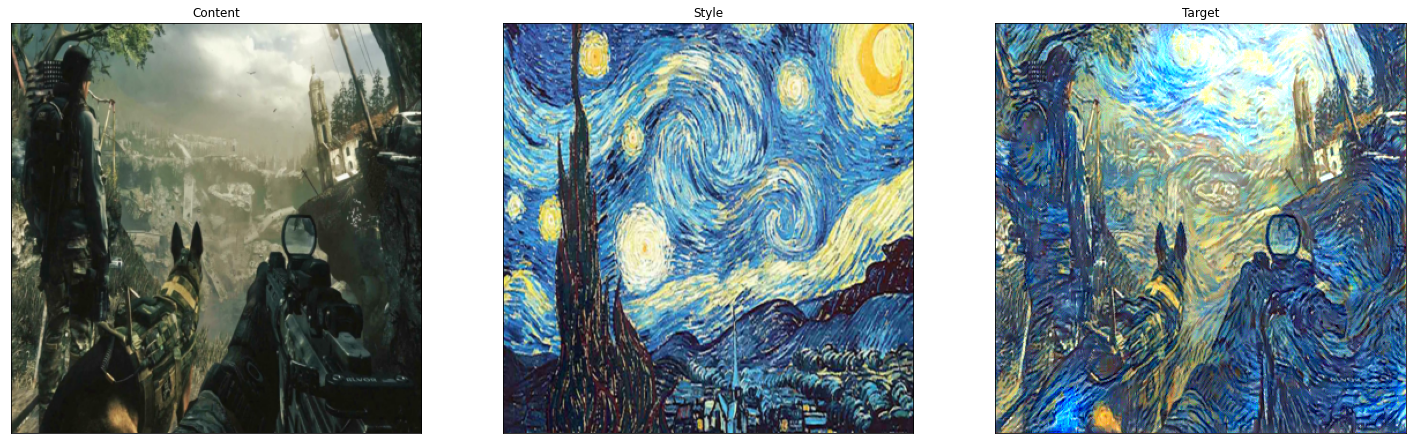

In [20]:
plt.figure(figsize=(25, 25))
plt.subplot(131)
plt.title('Content')
plt.imshow(content_img[0].cpu().permute(1, 2, 0))
plt.xticks([])
plt.yticks([])

plt.subplot(132)
plt.title('Style')
plt.imshow(style_img[0].cpu().permute(1, 2, 0))
plt.xticks([])
plt.yticks([])

plt.subplot(133)
plt.title('Target')
plt.imshow(target[0].cpu().permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])

plt.show()